# Fraud Detection Project: E-Commerce & Credit Card Data

# 1. Project Setup

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ipaddress

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score
from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier

import shap

# 2. Load and Inspect Data

In [3]:
fraud_df = pd.read_csv('../data/Fraud_Data.csv')
ip_df = pd.read_csv('../data/IpAddress_to_Country.csv')
credit_df = pd.read_csv('../data/creditcard.csv')

# 3. Cleaning and Preprocessin

In [4]:
fraud_df['signup_time'] = pd.to_datetime(fraud_df['signup_time'])
fraud_df['purchase_time'] = pd.to_datetime(fraud_df['purchase_time'])
fraud_df.drop_duplicates(inplace=True)

# 4. Exploratory Data Analysis (EDA)

C:\Users\user\AppData\Local\Temp\ipykernel_17300\766289419.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='class', data=fraud_df, palette='Set2')
C:\Users\user\AppData\Local\Temp\ipykernel_17300\766289419.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='class', y='purchase_value', data=fraud_df, palette='coolwarm')


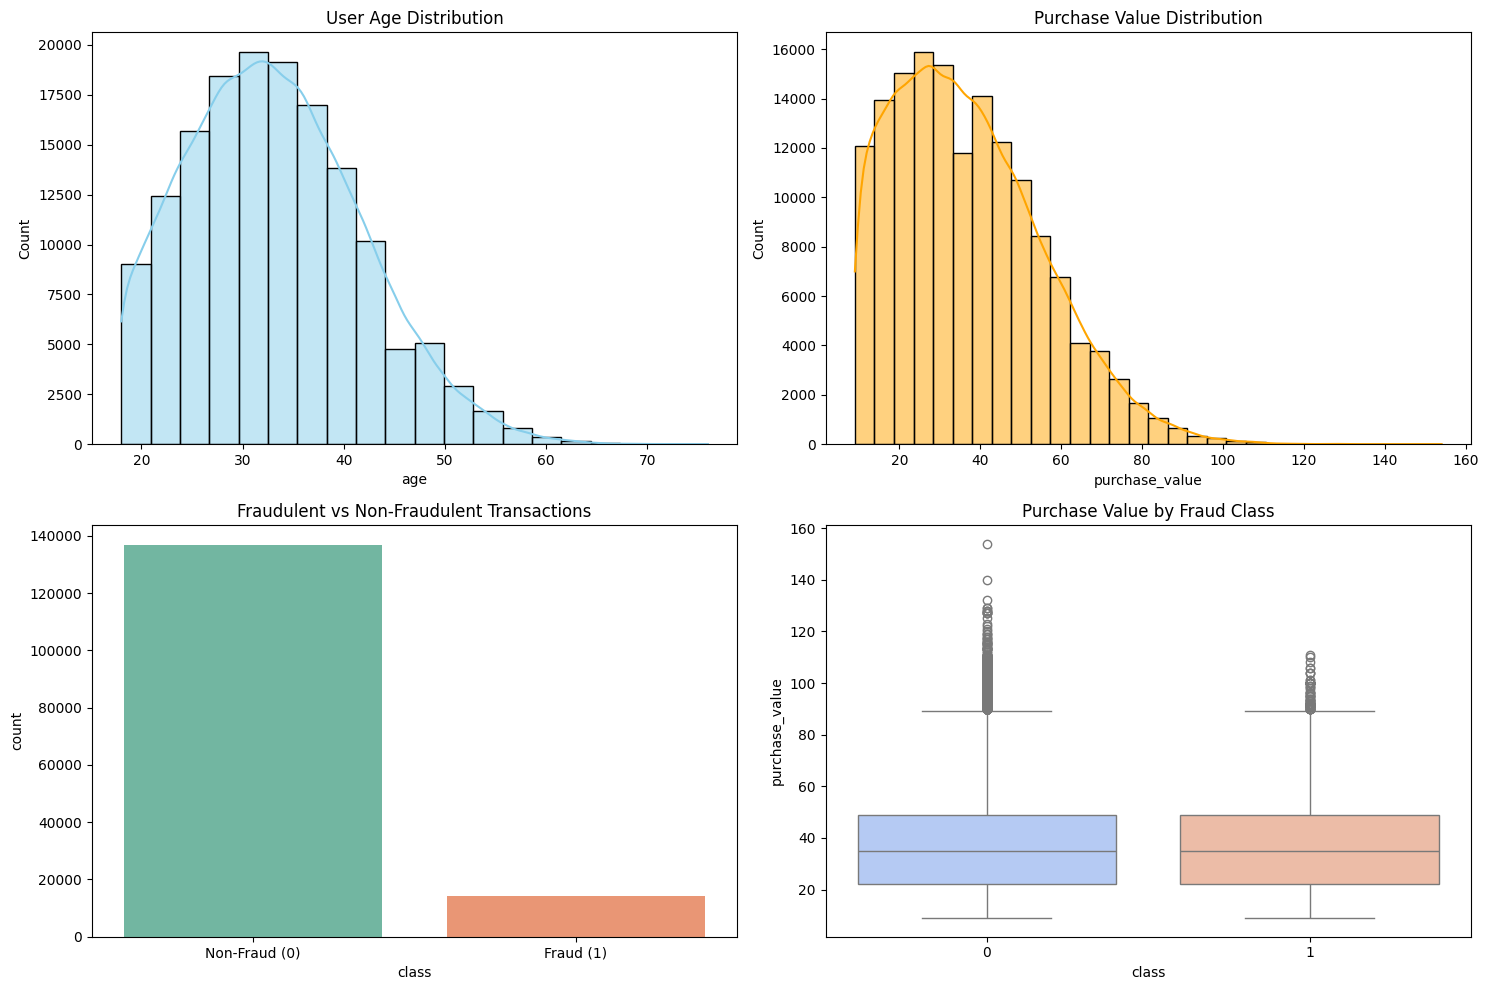

In [5]:
plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
sns.histplot(fraud_df['age'], kde=True, bins=20, color='skyblue')
plt.title("User Age Distribution")
plt.subplot(2, 2, 2)
sns.histplot(fraud_df['purchase_value'], kde=True, bins=30, color='orange')
plt.title("Purchase Value Distribution")
plt.subplot(2, 2, 3)
sns.countplot(x='class', data=fraud_df, palette='Set2')
plt.title("Fraudulent vs Non-Fraudulent Transactions")
plt.xticks([0, 1], ['Non-Fraud (0)', 'Fraud (1)'])
plt.subplot(2, 2, 4)
sns.boxplot(x='class', y='purchase_value', data=fraud_df, palette='coolwarm')
plt.title("Purchase Value by Fraud Class")
plt.tight_layout()
plt.show()


# 5. IP to Country 

In [15]:
# Define your function first
def to_ip_int(val):
    if pd.isna(val):
        return np.nan
    if isinstance(val, (float, int)):
        return int(val)
    else:
        try:
            return int(ipaddress.ip_address(val))
        except ValueError:
            return np.nan

# Then load your data
fraud_df = pd.read_csv('../data/Fraud_Data.csv')
ip_df = pd.read_csv('../data/IpAddress_to_Country.csv')

# Now apply the conversion
fraud_df['ip_int'] = fraud_df['ip_address'].apply(to_ip_int)
ip_df['lower'] = ip_df['lower_bound_ip_address'].apply(to_ip_int)
ip_df['upper'] = ip_df['upper_bound_ip_address'].apply(to_ip_int)

# Drop invalid IPs
fraud_df = fraud_df.dropna(subset=['ip_int'])
ip_df = ip_df.dropna(subset=['lower', 'upper'])

# Drop nulls in keys first
fraud_df = fraud_df.dropna(subset=['ip_int'])
ip_df = ip_df.dropna(subset=['lower'])

# Sort both DataFrames by join keys ASCENDING
fraud_df = fraud_df.sort_values('ip_int').reset_index(drop=True)
ip_df = ip_df.sort_values('lower').reset_index(drop=True)

# Confirm no nulls remain
assert fraud_df['ip_int'].isnull().sum() == 0
assert ip_df['lower'].isnull().sum() == 0

# Merge_asof
merged_df = pd.merge_asof(fraud_df, ip_df, left_on='ip_int', right_on='lower', direction='backward')

# 6. Feature Engineering

In [17]:

merged_df['purchase_time'] = pd.to_datetime(merged_df['purchase_time'], errors='coerce')
merged_df['signup_time'] = pd.to_datetime(merged_df['signup_time'], errors='coerce')
merged_df['hour_of_day'] = merged_df['purchase_time'].dt.hour
merged_df['day_of_week'] = merged_df['purchase_time'].dt.dayofweek
merged_df['time_since_signup'] = (merged_df['purchase_time'] - merged_df['signup_time']).dt.total_seconds()
user_freq = merged_df.groupby('user_id').size().rename('user_transaction_count')
merged_df = merged_df.merge(user_freq, on='user_id')


# 7. Prepare features and target

In [18]:
X = merged_df.drop(['class', 'signup_time', 'purchase_time', 'ip_address', 'ip_int', 'lower', 'upper', 'country'], axis=1)
y = merged_df['class']

# 8. Define preprocessor

In [19]:
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)


# 9. Split train/test

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

X_train_trans = preprocessor.fit_transform(X_train)
X_test_trans = preprocessor.transform(X_test)


# 10. Manual upsampling fraud dataset

In [ ]:
#train_df = pd.DataFrame(X_train_trans.toarray() if hasattr(X_train_trans, "toarray") else X_train_trans)
import scipy.sparse

if scipy.sparse.issparse(X_train_trans):
    train_df = pd.DataFrame.sparse.from_spmatrix(X_train_trans)
else:
    train_df = pd.DataFrame(X_train_trans)
train_df['class'] = y_train.reset_index(drop=True)

majority = train_df[train_df['class'] == 0]
minority = train_df[train_df['class'] == 1]

minority_upsampled = resample(minority,
                              replace=True,
                              n_samples=len(majority),
                              random_state=42)

upsampled_df = pd.concat([majority, minority_upsampled]).sample(frac=1, random_state=42)

X_resampled = upsampled_df.drop('class', axis=1)
y_resampled = upsampled_df['class']

## Train model on fraud data

In [ ]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_resampled, y_resampled)

y_pred = model.predict(X_test_trans)

print("\n--- Fraud Dataset Results ---")
print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_pred))
print("PR AUC:", average_precision_score(y_test, y_pred))


# SHAP explainability

In [ ]:
explainer = shap.Explainer(model, X_resampled)
shap_values = explainer(X_resampled[:100])
shap.plots.beeswarm(shap_values)


# Credit Card Dataset

In [ ]:
X_cc = credit_df.drop('Class', axis=1)
y_cc = credit_df['Class']

X_train_cc, X_test_cc, y_train_cc, y_test_cc = train_test_split(X_cc, y_cc, test_size=0.3, stratify=y_cc, random_state=42)

scaler = StandardScaler()
X_train_cc_scaled = scaler.fit_transform(X_train_cc)
X_test_cc_scaled = scaler.transform(X_test_cc)


# Manual upsampling credit card dataset

In [ ]:
train_cc_df = pd.DataFrame(X_train_cc_scaled)
train_cc_df['class'] = y_train_cc.reset_index(drop=True)

majority_cc = train_cc_df[train_cc_df['class'] == 0]
minority_cc = train_cc_df[train_cc_df['class'] == 1]

minority_upsampled_cc = resample(minority_cc,
                                 replace=True,
                                 n_samples=len(majority_cc),
                                 random_state=42)

upsampled_cc_df = pd.concat([majority_cc, minority_upsampled_cc]).sample(frac=1, random_state=42)

X_resampled_cc = upsampled_cc_df.drop('class', axis=1)
y_resampled_cc = upsampled_cc_df['class']

model_cc = RandomForestClassifier(n_estimators=100, random_state=42)
model_cc.fit(X_resampled_cc, y_resampled_cc)

y_pred_cc = model_cc.predict(X_test_cc_scaled)

print("\n--- Credit Card Dataset Results ---")
print(classification_report(y_test_cc, y_pred_cc))
print("ROC AUC:", roc_auc_score(y_test_cc, y_pred_cc))
print("PR AUC:", average_precision_score(y_test_cc, y_pred_cc))